# Quantifying differences between characters in _The Moonstone_

## Kenneth Khuu

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer, SentimentAnalyzer

import collections
from collections import Counter

### Introduction

As we read through _The Moonstone,_ we subconsciously notice the differences between narrators, their speech, and their narratives. Through speech patterns, vocabulary, polarity, (or any combination of features such as these) it is relatively easy for us to be presented a passage out-of-context and be able to decipher who the quote belongs to. The goal of my project to see if we can use computational literary analysis to quantify the differences between each narrator in _The Moonstone_ and have it recreate what human readers are able to do instinctively. If possible, how well will this work and what combination of features is best?

Before any literary analysis is done, we need to clean and recreate a corpus for _The Moonstone_ to make calculations possible.

In [7]:
moonstone = open('moonstone.md', encoding = 'utf8').read()

In [8]:
moonstone_parts = moonstone.split('\n##')
moonstone_parts2 = moonstone.split('\n## ')

In [9]:
prologue = str(moonstone_parts[1:5])
betteredge = str(moonstone_parts[5:29])
clack = str(moonstone_parts2[3])
bruff = str(moonstone_parts2[4])
blake = str(moonstone_parts2[5])
jennings = str(moonstone_parts2[6])
blake2 = str(moonstone_parts2[7])
cuff = str(moonstone_parts2[8])
candy = str(moonstone_parts2[9])
betteredge2 = str(moonstone_parts2[10])
epilogue = str(moonstone_parts2[11])

In [10]:
#Final corpus in both list and string form to cover all use cases
full_moonstone = [prologue, betteredge, clack, bruff, blake, jennings, blake2, cuff, candy, betteredge2, epilogue]
full_moonstone_str = str([prologue, betteredge, clack, bruff, blake, jennings, blake2, cuff, candy, betteredge2, epilogue])
moonstone_sentences = [nltk.sent_tokenize(text) for text in full_moonstone]

In [11]:
#Creating tokenized Texts with titles for each narrative
prologue_text = nltk.Text(nltk.word_tokenize(prologue), name = "Prologue")
betteredge_text = nltk.Text(nltk.word_tokenize(betteredge), name = "Betteredge's narrative")
clack_text = nltk.Text(nltk.word_tokenize(clack), name = "Clack's narrative")
bruff_text = nltk.Text(nltk.word_tokenize(bruff), name = "Bruff's narrative")
blake_text = nltk.Text(nltk.word_tokenize(blake), name = "Blake's narrative")
jennings_text = nltk.Text(nltk.word_tokenize(jennings), name = "Jennings' narrative")
blake2_text = nltk.Text(nltk.word_tokenize(blake2), name = "Blake's second narrative")
cuff_text = nltk.Text(nltk.word_tokenize(cuff), name = "Cuff's narrative")
candy_text = nltk.Text(nltk.word_tokenize(candy), name = "Candy's narrative")
betteredge2_text = nltk.Text(nltk.word_tokenize(betteredge2), name = "Betteredge's second narrative")
epilogue_text = nltk.Text(nltk.word_tokenize(epilogue), name = "Epilogue")

### Type-token ratio /  vocabulary analysis

A rather obvious choice for numerically analyzing narrators is by comparing type-token ratios (TTRs). A type-token ratio is given by a single value between 0 and 1 and helps us discern how complex someone's vocabulary is. A high TTR implies that the speaker has a high level of lexical variation while a low TTR implies that the narrator has a rather basic vocabulary (calculated to have a lower amount of unique words). 

Below is a function that helps us calculate type-token ratios as well as a simple list containing each narrator's TTRs.

In [12]:
#Function that tokenizes a string input and calculates its type-token ratio
def type_token_ratio(text_string):
    text_string = text_string.lower()
    num_tokens = len(nltk.word_tokenize(text_string))
    num_types = len(set(nltk.word_tokenize(text_string)))
    return num_types / num_tokens

In [13]:
#Creates a new list with type/token ratio of each narrative
ttrs = []
ttrs.append('Prologue: ' + str(type_token_ratio(prologue)))
ttrs.append('Betteredge: ' + str(type_token_ratio(betteredge)))
ttrs.append('Clack: ' + str(type_token_ratio(clack)))
ttrs.append('Bruff: ' + str(type_token_ratio(bruff)))
ttrs.append('Blake: ' + str(type_token_ratio(blake)))
ttrs.append('Jennings: ' + str(type_token_ratio(jennings)))
ttrs.append('Blake #2: ' + str(type_token_ratio(blake2)))
ttrs.append('Cuff: ' + str(type_token_ratio(cuff)))
ttrs.append('Candy: ' + str(type_token_ratio(candy)))
ttrs.append('Betteredge #2: ' + str(type_token_ratio(betteredge2)))
ttrs.append('Epilogue: ' + str(type_token_ratio(epilogue)))
ttrs

['Prologue: 0.35958005249343833',
 'Betteredge: 0.12001403937819141',
 'Clack: 0.11688132601560992',
 'Bruff: 0.16493570722057369',
 'Blake: 0.0916559741080491',
 'Jennings: 0.14359003919760202',
 'Blake #2: 0.16950499545867392',
 'Cuff: 0.2293471981513576',
 'Candy: 0.37003058103975534',
 'Betteredge #2: 0.3783231083844581',
 'Epilogue: 0.3043134151167392']

After calculating the type-token ratio for each narrative, some of the results are interesting as they seem to be against our intuition. For example, Cuff's TTR is supposedly higher than Bruff's TTR (0.229 vs 0.165) which is somewhat surprising considering that Bruff is the family lawyer (and it is reasonable to assume that a lawyer would have the greatest lexicon out of all the main characters). Another interesting type-token ratio factoid is that while Blake's 2nd narrative has a higher TTR than his first, Betteredge's 2nd narrative has a TTR that is three times as high! (0.378 vs 0.12)

To delve deeper into this, I defined a counter function below and created a new simple list containing the word count of each narrative (based off of collections' Counter function).

In [14]:
#Counter function that strips punctuation and counts the number of tokens
def counted(text_string):
    lowered = text_string.lower()
    lowered = lowered.replace('–', ' – ')
    lowered = lowered.replace('*', ' ')
    lowered = lowered.replace(',', ' ')
    lowered = lowered.replace('“', ' ')
    lowered = lowered.replace('”', ' ')
    lowered = lowered.replace('’', ' ')
    lowered = lowered.replace('–', ' ')
    lowered = lowered.replace('.', ' ')
    lowered = lowered.replace('\\n\\n', ' ')
    lowered = lowered.replace('\\n', ' ')
    tokens = nltk.word_tokenize(lowered)
    counted = Counter(tokens)
    return counted

In [15]:
#Length of each text or text segment, in words.
word_counts = []
word_counts.append('Prologue: ' + str(len(counted(prologue))))
word_counts.append('Betteredge: ' + str(len(counted(betteredge))))
word_counts.append('Clack: ' + str(len(counted(clack))))
word_counts.append('Bruff: ' + str(len(counted(bruff))))
word_counts.append('Blake: ' + str(len(counted(blake))))
word_counts.append('Jennings: ' + str(len(counted(jennings))))
word_counts.append('Blake #2: ' + str(len(counted(blake2))))
word_counts.append('Cuff: ' + str(len(counted(cuff))))
word_counts.append('Candy: ' + str(len(counted(candy))))
word_counts.append('Betteredge #2: ' + str(len(counted(betteredge2))))
word_counts.append('Epilogue: ' + str(len(counted(epilogue))))
word_counts

['Prologue: 723',
 'Betteredge: 5589',
 'Clack: 3825',
 'Bruff: 1902',
 'Blake: 4191',
 'Jennings: 2326',
 'Blake #2: 1395',
 'Cuff: 1150',
 'Candy: 350',
 'Betteredge #2: 352',
 'Epilogue: 760']

As we can see, Betteredge's second narrative is one of the shortest in _The Moonstone!_ It is likely that this had a large part in the tripling of the type-token ratio between his first and second narrative. Some of the other narratives with the high TTRs include the "non-traditional" narratives: the prologue (which is from the family papers), the epilogue (which is written in three parts by three different people), and Mr. Candy's narrative (a letter to Franklin Blake).

### Sentiment analysis with VADER

A very nifty thing about computational literary analysis is that we can use the idea of "sentiment analysis" to analyze the  words in a sentence and calculate a measure of its sentiment. VADER is a lexicon and rule-based sentiment analysis tool that calculates the sentiment of individual words and returns a compound score based off the sum of each word and VADER's own algorithm and ruleset. One issue with VADER is that it lacks the ability to understand contextual clues that can vastly change how positive or negative a sentence is in reality. For example, ironic statements tend to use "positive" words when they are actually stating something negative (and vice versa). However, given the length of each narrative, I believe that VADER will do a fine job overall despite this issue.

The following code and function returns a normalized, weighted composite score:

In [71]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [72]:
[sentiment_analyzer.polarity_scores(text) for text in full_moonstone]

[{'neg': 0.081, 'neu': 0.844, 'pos': 0.075, 'compound': -0.9863},
 {'neg': 0.079, 'neu': 0.822, 'pos': 0.1, 'compound': 1.0},
 {'neg': 0.095, 'neu': 0.76, 'pos': 0.144, 'compound': 1.0},
 {'neg': 0.078, 'neu': 0.809, 'pos': 0.113, 'compound': 0.9999},
 {'neg': 0.09, 'neu': 0.802, 'pos': 0.108, 'compound': 1.0},
 {'neg': 0.073, 'neu': 0.815, 'pos': 0.112, 'compound': 1.0},
 {'neg': 0.066, 'neu': 0.859, 'pos': 0.075, 'compound': 0.9974},
 {'neg': 0.062, 'neu': 0.85, 'pos': 0.088, 'compound': 0.9989},
 {'neg': 0.091, 'neu': 0.794, 'pos': 0.116, 'compound': 0.9855},
 {'neg': 0.044, 'neu': 0.86, 'pos': 0.096, 'compound': 0.9913},
 {'neg': 0.061, 'neu': 0.838, 'pos': 0.101, 'compound': 0.9983}]

In [73]:
#Testing sentiment analysis on a narrative as a whole
sentiment_analyzer.polarity_scores(prologue)

{'neg': 0.081, 'neu': 0.844, 'pos': 0.075, 'compound': -0.9863}

In [74]:
#Testing sentiment analysis on a narrative as a sum of its sentences
sentiment_analyzer.polarity_scores(str(moonstone_sentences[0]))

{'neg': 0.078, 'neu': 0.851, 'pos': 0.071, 'compound': -0.9879}

As we can see, VADER does return a slightly different score when looking at a narrative as a whole vs. a narrative sentence by sentence. However, the difference is slight and so I will be calculating compound score by narrative for the sake of simplicity.

In [75]:
#Function that returns only the compound polarity score
def get_compound_sentiment(text):
    return sentiment_analyzer.polarity_scores(text)['compound']

In [76]:
#List of narrators to be used as column labels and plot labels
narrators_labels = ['prologue', 'betteredge', 'clack', 'bruff', 'blake', 'jennings', 'blake2', 'cuff', 'candy', 'betteredge2', 'epilogue']

In [77]:
compound_values = pd.DataFrame([get_compound_sentiment(text) for text in full_moonstone], index = narrators_labels)
compound_values = compound_values.rename(columns = {0: 'Compound polarity'})
compound_values

,Compound polarity
prologue,-0.9863
betteredge,1.0000
clack,1.0000
bruff,0.9999
blake,1.0000
jennings,1.0000
blake2,0.9974
cuff,0.9989
candy,0.9855
betteredge2,0.9913


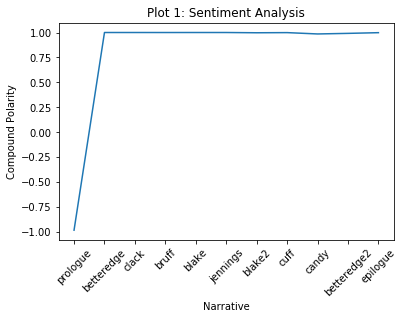

In [95]:
#Plot 1: Sentiment analysis by narrative
plt.plot(compound_values)
plt.xticks(rotation = 45)
plt.title('Plot 1: Sentiment Analysis')
plt.xlabel('Narrative')
plt.ylabel('Compound Polarity');

For some reason, all narratives have a compound polarity of 1 except the prologue which has a polarity of close to -1!

Ignoring the prologue, seeing each narrative have a compound polarity between 0.99 and 1 is not useful at all when comparing narratives in _The Moonstone._ All narrators have a small amount of positive sentiment and negative sentiment, but none are drastic enough in either direction for us to use VADER and say that "x narrator is distinct from others because he/she is vastly more negative in sentiment throughout their narrative."

### Latent Dirichlet Allocation (LDA)

Latent dirichlet allocation is a form of unsupervised modelling that does not make a prediction like a standard model would under supervised modelling. Using LDA allows us to discover topics and themes that are not immediate to us as readers and then classifies each text by these topics without a traditional x-input and y-prediction model.

In [85]:
#Initialize CountVectorizer with parameters I found to have best fit the dataset
count_vectorizer = CountVectorizer(stop_words='english', min_df=3, max_df=0.7, max_features=5000)

In [86]:
narrators_counts = count_vectorizer.fit_transform(full_moonstone)
narrators_counts

<11x2454 sparse matrix of type '<class 'numpy.int64'>'
	with 10522 stored elements in Compressed Sparse Row format>

In [87]:
word_labels = count_vectorizer.get_feature_names()

In [88]:
#Subfigure DataFrame with word counts by narrative
narrators_df = pd.DataFrame(narrators_counts.todense(), index = narrators_labels, columns = word_labels)
narrators_df

,1849,ability,able,ablewhite,ablewhites,abominable,abroad,abruptly,absence,absolutely,...,wrote,wrought,yard,yellow,yes,yesterday,yorkshire,young,younger,youth
prologue,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
betteredge,0,2,5,2,4,5,6,0,2,3,...,6,1,8,7,39,6,4,75,3,1
clack,0,1,5,82,3,2,0,0,3,4,...,1,2,0,0,16,4,3,21,0,1
bruff,0,1,1,17,0,0,0,0,0,3,...,1,0,0,0,6,1,5,4,1,0
blake,0,1,12,10,1,2,3,4,4,3,...,4,0,3,0,22,4,9,8,0,1
jennings,1,0,3,0,0,0,0,2,1,0,...,3,1,0,0,8,8,4,7,1,1
blake2,0,0,2,2,0,0,0,1,0,0,...,3,0,0,0,6,1,2,0,0,1
cuff,1,0,0,31,0,0,1,0,1,1,...,0,0,1,0,0,0,0,6,0,0
candy,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
betteredge2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


From the dataframe above, we can immediately see the varying frequencies at which certain words are used by each narrator. Note, the counts are not divided by the number of words in each narrative so these are not true frequencies (by percentage) but rather raw counts of each word by each narrative. 

We can see that "ablewhite" is mentioned in Clack's narrative 82 times, far more than any in any other narrative. Similarly, Betteredge's first narrative has 75 counts of the word young - possibly due to the fact that he is older than many of the other narrators in _The Moonstone._

An LDA plot can also help us see how our model makes predictions for each narrative. I use 4 n_components as it still gives us valuable data without cluttering our plot with a large legend and too many colors.

In [119]:
lda = LatentDirichletAllocation(n_components = 4)

In [120]:
lda_out = lda.fit_transform(narrators_counts)

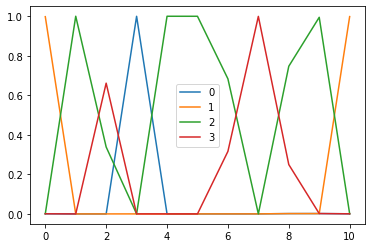

In [121]:
#A pre-processed LDA plot
pd.DataFrame(lda_out).plot()

In [122]:
lda.components_.shape

(4, 2454)

In [123]:
topic_word_matrix = pd.DataFrame(lda.components_, index = ['Topic ' + str(x) for x in range(4)], columns = word_labels)
topic_word_matrix

,1849,ability,able,ablewhite,ablewhites,abominable,abroad,abruptly,absence,absolutely,...,wrote,wrought,yard,yellow,yes,yesterday,yorkshire,young,younger,youth
Topic 0,0.250009,1.250019,1.249982,17.250291,0.250000,0.250000,0.250001,0.250001,0.250001,3.250080,...,1.250030,0.250001,0.250001,0.250001,6.250248,1.250011,5.250559,4.249992,1.250018,0.250001
Topic 1,2.252127,0.250001,2.250083,0.250001,0.250001,0.250001,0.250002,0.250002,0.250001,0.250001,...,0.250002,0.250001,0.250002,4.250088,1.249643,0.250002,0.250003,0.250001,0.250001,0.250002
Topic 2,1.573637,3.848789,24.041968,13.389517,5.947703,8.415353,9.250015,7.244070,7.893813,6.848486,...,16.714910,2.519821,11.250032,7.249911,81.481885,21.358150,21.883589,98.069639,4.249981,4.133863
Topic 3,1.924227,0.651190,3.457966,114.110191,2.552296,1.084646,1.249982,0.255927,3.606185,4.651433,...,0.785058,1.980176,1.249965,0.250000,10.018224,2.141837,1.615850,19.430367,0.250000,1.366134


In [124]:
#Function that returns a "topic" - list of the top five words
def get_words(topic_name):
    return ' '.join(list(topic_word_matrix.loc[topic_name].sort_values(ascending = False).head(5).index))

In [125]:
topic_labels_words = [get_words(topic) for topic in ['Topic ' + str(x) for x in range(4)]]

In [126]:
pd.DataFrame(lda_out, columns = topic_labels_words, index = narrators_labels)

,luker murthwaite bruff ablewhite office,sacred moon herncastle india cousin,sergeant rachel cuff don says,godfrey ablewhite rachel aunt dear
prologue,0.000742,0.997768,0.000747,0.000743
betteredge,0.000018,0.000018,0.999945,0.000019
clack,0.000038,0.000037,0.338517,0.661409
bruff,0.999636,0.000119,0.000123,0.000123
blake,0.000030,0.000030,0.999855,0.000085
jennings,0.000085,0.000083,0.999745,0.000087
blake2,0.000171,0.000167,0.683313,0.316350
cuff,0.000265,0.000263,0.000271,0.999200
candy,0.001665,0.001695,0.747009,0.249631
betteredge2,0.001848,0.001714,0.994617,0.001820


Creating a topic word matrix and a supporting function that draws the 5 words with the highest values allows us to see what our LDA model believes to be the discernable topics to categorize each narrative into (limited to 4 as stated above). Our final LDA plot incorporates these topics to increase readability. 

_Plot #2_ is as follows:

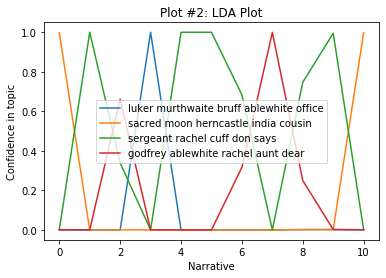

In [142]:
pd.DataFrame(lda_out, columns = topic_labels_words).plot()
plt.title('Plot #2: LDA Plot')
plt.xlabel('Narrative')
plt.ylabel('Confidence in topic');

From this plot, we can see that the orange line does a very accurate job with the topic of both the prologue and epilogue (using topics like sacred, herncastle, and india). Topics 2 (green), 3 (red), and 0 (blue) correspond with Betteredge, Clack, and Bruff's narratives respectively so it makes sense that they are identified distinctly. Clack's (red, topic 3) has distinct words such as "godfrey" and "aunt" which makes sense as a reader since she praises Godfrey throughout her narrative and distinctively refers to Rachel as her aunt (due to being her niece). 

Similarly, Bruff's (topic 0) includes words such as "luker" and "murthwaite" due to his investigations into the Indians and the moneylender. Betteredge's, shown by orange, does identify his 2nd narrative (9th narrative per the x-axis) later on in the text.

Interesting note: topics are out of order when compared to narrative order!

## Term frequency–inverse document frequency (tf-idf)

The final quantitative statistic I want to explore is term frequency-inverse document frequency (denoted as tf-idf). After calculating tf-idf per narrative, we will have the ability to see how important a word is to a document in a corpus (or in our case, how important a word is to a narrative in _The Moonstone)_. Below, I will modify TfidfVectorizer's parameters to only accept words that appear in atleast 60% of our narratives. Limiting our tfidf vectorizer to words that appear across all narratives will return less than 100 features. In my opinion, having around 500 words is a better metric and there are 600 words that appear in at least 60% of the narratives in the story.

In [71]:
#Modify TfidfVectorizer to require a word to appear in at least 60% of documents
tfidf_vectorizer = TfidfVectorizer(min_df = 0.6, use_idf = False)

In [72]:
moonstone_freq = tfidf_vectorizer.fit_transform(full_moonstone).todense()

In [73]:
#Create a DataFrame to show each word's frequency in each narrative
moonstone_df = pd.DataFrame(moonstone_freq, columns = tfidf_vectorizer.get_feature_names(), index = narrators_labels)
moonstone_df

,able,about,acting,add,addressed,afraid,after,afterwards,again,against,...,written,year,years,yes,yet,yorkshire,you,your,yours,yourself
prologue,0.000000,0.011621,0.000000,0.000000,0.000000,0.000000,0.011621,0.000000,0.007747,0.000000,...,0.007747,0.000000,0.007747,0.000000,0.003874,0.000000,0.015495,0.003874,0.003874,0.000000
betteredge,0.000697,0.024257,0.000697,0.001533,0.001255,0.002509,0.018402,0.001533,0.019099,0.004182,...,0.002509,0.001533,0.003346,0.005437,0.003764,0.000558,0.109434,0.035270,0.000976,0.002230
clack,0.001801,0.011885,0.000360,0.003241,0.002521,0.001801,0.012605,0.002161,0.019448,0.001441,...,0.002521,0.000360,0.002161,0.005762,0.006122,0.001080,0.123528,0.037455,0.001441,0.004682
bruff,0.000928,0.017624,0.001855,0.004638,0.000928,0.000928,0.015769,0.002783,0.009276,0.001855,...,0.004638,0.003710,0.002783,0.005565,0.000928,0.004638,0.089047,0.024117,0.000000,0.002783
blake,0.002782,0.013908,0.001623,0.000695,0.001159,0.002550,0.019471,0.004636,0.024571,0.005331,...,0.002086,0.004404,0.001854,0.005100,0.005795,0.002086,0.224153,0.055864,0.001854,0.007418
jennings,0.002027,0.005407,0.001352,0.000676,0.002027,0.002703,0.018247,0.000676,0.025681,0.005407,...,0.005407,0.018247,0.004055,0.005407,0.006082,0.002703,0.072989,0.015544,0.002027,0.000676
blake2,0.002462,0.019700,0.001231,0.002462,0.001231,0.001231,0.029550,0.004925,0.019700,0.001231,...,0.006156,0.003694,0.001231,0.007387,0.007387,0.002462,0.076337,0.018469,0.001231,0.002462
cuff,0.000000,0.001877,0.001877,0.001877,0.001877,0.000000,0.013138,0.003754,0.018768,0.001877,...,0.003754,0.016891,0.000000,0.000000,0.003754,0.000000,0.106979,0.039413,0.001877,0.005630
candy,0.000000,0.000000,0.000000,0.000000,0.000000,0.011644,0.011644,0.011644,0.023287,0.000000,...,0.011644,0.011644,0.011644,0.000000,0.000000,0.000000,0.174655,0.046575,0.011644,0.000000
betteredge2,0.000000,0.027716,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013858,0.000000,...,0.013858,0.000000,0.000000,0.000000,0.013858,0.013858,0.277164,0.055433,0.013858,0.013858


## Principal component analysis (PCA)

As seen above, the shape of our moonstone_df is 11 rows x 600 columns. As humans, we have a lot of difficulty understanding visualizations above 2d space, so plotting a model with 600 features would be impossible. Principal component analysis allows us to visualize the relationship between all our words and their corresponding narratives with a two-dimensional plot.

In [74]:
pca = PCA(n_components = 2)

In [84]:
#Show that the new shape is 11 x 2 from 11 x 600
moonstone_reduced = pca.fit_transform(moonstone_freq)
moonstone_reduced.shape

(11, 2)

In [76]:
#Pre-processed array of PC1 and PC2 values
moonstone_reduced

array([[-0.24196894, -0.10209113],
       [ 0.00774726,  0.03962561],
       [ 0.06559926,  0.06439087],
       [-0.01896806,  0.01105134],
       [ 0.05923949,  0.10054291],
       [ 0.04014251, -0.03295629],
       [-0.08047824, -0.08958079],
       [-0.10117556, -0.0671149 ],
       [ 0.47562697, -0.19595012],
       [ 0.06973255,  0.34904301],
       [-0.27549724, -0.0769605 ]])

In [77]:
#Subfigure that clearly shows PC1 and PC2 values for each narrative
moonstone_reduced_df = pd.DataFrame(moonstone_reduced, index = narrators_labels, columns = ['PC1', 'PC2'])
moonstone_reduced_df

,PC1,PC2
prologue,-0.241969,-0.102091
betteredge,0.007747,0.039626
clack,0.065599,0.064391
bruff,-0.018968,0.011051
blake,0.059239,0.100543
jennings,0.040143,-0.032956
blake2,-0.080478,-0.089581
cuff,-0.101176,-0.067115
candy,0.475627,-0.195950
betteredge2,0.069733,0.349043


With values for PC1 and PC2 for each narrative, we can now plot these points onto a 2d scatterplot and analyze the relationship between narratives by looking at the location of each point. Points that are clustered imply some relationship between them.

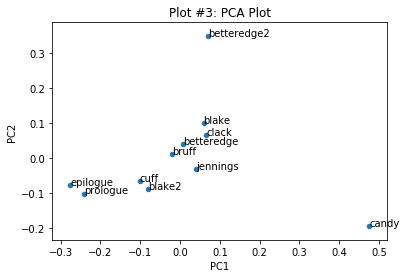

In [83]:
pca_plot = moonstone_reduced_df.plot(kind='scatter', x = 'PC1', y = 'PC2')
for title, points in moonstone_reduced_df.iterrows():
    pca_plot.annotate(title, points)
plt.title('Plot #3: PCA Plot');

Our PCA plot shows a few interesting data points. Perhaps most noticeable is that Candy's narrative is by far the most distinct according to our tf-idf model, boasting a very high PC1 value and low PC2 value. As stated above, Candy's narrative is actually in the form of a letter to Franklin Blake so that might have had a huge part in its place on this plot.

Another interesting point on apart from the main cluster of points is Betteredge's 2nd narrative, which has a very high PC2 value despite a rather standard PC1 value. I'm not sure why this is, but we do know from our word count and TTR analysis that Betteredge's 2nd narrative is one of the shortest and boasts a very high type-token ratio. 

One mini-cluster we can see contains both the epilogue and prologue, both having low PC1 and PC2 values. This of course makes sense as the serve as an introduction and conclusion for _The Moonstone_ and are not a traditional narrative with one narrator.

## Conclusion

Throughout this project, I have calculated numerical statistics such as type-token ratio (and further analysis with word count), sentiment, LDA, and tf-idf (utilizing PCA to allow me to visualize it). 

The biggest surprise is perhaps the rather ineffectiveness of using (compound) sentiment analysis in distinguishing between narrators. A compound sentiment of around 1 for every main narrator is of course useless when trying to decipher between them.

However, many of the other forms of analysis did result in interesting results. Computed TTRs per narrator varied from 0.1 to 0.4, with narrators like Cuff have a type-token ratio twice has high as someone like Clack. Our LDA model was able to generate different topics that are able to accurately classify the first 4 narratives. It is my belief that, were we to ignore readability and change some of the LDA parameters, we would be able to come up with a model for most (if not all narratives) and then use that data to read in random sentences and classify those by topic/narrator. As for tf-idf, we were able to find distinct narratives such as Candy's and Betteredge's 2nd, but the vast majority are clustered around a value of zero for both PC1 and PC2. With this, we would only be able to identify with confidence if a random sentence is from one of those two narratives or from the epilogue/prologue. 

With the uncertainty/general ineffectiveness around tf-idf and sentiment analysis, we are only left with type-token ratios and latent dirichlet allocation as plausible methods of deciphering which narrative a piece of text is from. In my opinion, these two models' results are not unique enough to effectively assign narrator to a random piece of text. Because of this, the answer to my question "Can we use computational literary analysis to quantify the differences between each narrator in The Moonstone and have it recreate what human readers are able to do instinctively? If possible, how well will this work and what combination of features is best?" is that no, CLA (through the models I explored today) are not particular effective at quantifying the differences between each narrator in _The Moonstone._ Were I insistent on trying to do so, I would most definitely pay attention to TTR and LDA and try to build from that.

## Works Cited

Ganegedara, Thushan. “Intuitive Guide to Latent Dirichlet Allocation.” Medium, Towards Data Science, 27 Mar. 2019, towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158.

Hug, Josh. “Lecture 23 – Principal Component Analysis.” Data 100, 2019, www.ds100.org/su20/lecture/lec23/.

Pandey, Parul. “Simplifying Sentiment Analysis Using VADER in Python (on Social Media Text).” Medium, Analytics Vidhya, 8 Nov. 2019, medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f.

“Sklearn.feature_extraction.Text.TfidfVectorizer¶.” Scikit, scikit-
learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html.

Thomas, Dax. Type-Token Ratios in One Teacher’s Classroom Talk: An Investigation of Lexical Complexity, 2005, www.birmingham.ac.uk/Documents/college-artslaw/cels/essays/languageteaching/DaxThomas2005a.pdf.